In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import random
import pickle as pkl
import pandas as pd
# from tensorflow import keras
# from tensorflow.keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model
# from tensorflow.keras import layers
import matplotlib.pyplot as plt
# tf.keras.backend.clear_session()

In [2]:
class Linear(layers.Layer):
    '''
    Class for initializing a layer in Neural Network
    '''
    def __init__(self, units=32):
        '''
        constructor
        :param units: number of nodes in the layer
        '''
        super(Linear, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        '''
        Initialize weight and bias values of the layer
        :param w: weights
        :param b: bias
        '''
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
        
    def call(self, inputs):
        '''
        layer output
        '''
        return tf.matmul(inputs, self.w) + self.b

In [25]:
class NTBlock(layers.Layer):
    '''
    Neurotranmitter Block
    '''
    def __init__(self):
        super(NTBlock, self).__init__()
        self.layers = []
        self.layers.append(Linear(256))
        self.layers.append(Linear(128))
        self.layers.append(Linear(256))
        self.layers.append(Linear(784))
#         self.layers.append(Linear(1))
        
    def call(self, inputs, calc_loss=False):
        # store layers in decoder to decoder_layers
        decoder_layers = []
        x = self.layers[0](inputs)
        # Z1 = first layer with 312 neurons
        Z1 = tf.nn.sigmoid(x)
        Z2 = self.layers[1](Z1)
        # Z2 = second layer with 128 neurons
        Z2 = tf.nn.sigmoid(Z2)
        # collect the hidden layer in decoder_layers
        decoder_layers.insert(0, Z2)
        Z1_bar = self.layers[2](Z2)
        # Z1_bar = back to first layer with 312 neurons
        Z1_bar = tf.nn.sigmoid(Z1_bar)
        decoder_layers.insert(0, Z1_bar)
        x_bar = self.layers[3](Z1_bar)
        # x_bar = back to input layer with 784 neurons
        x_bar = tf.nn.sigmoid(x_bar)
        
        if calc_loss:
            # calculate layer wise loss in autoencoder
            nt_loss = custom_bce(Z1_bar, Z1) * Z1.shape[0] + custom_bce(x_bar, inputs) * inputs.shape[0]
            return x_bar, nt_loss
        else:
            return x_bar, decoder_layers

In [26]:
class MLPBlock(layers.Layer):
    '''
    Neural Network Block
    '''
    def __init__(self):
        '''
        Architecture of the neural network i.e.
        number of layers and nodes in each layer
        '''
        super(MLPBlock, self).__init__()
        self.layers = []
        self.layers.append(Linear(256))
        self.layers.append(Linear(128))
        self.layers.append(Linear(1))
        
    def call(self, inputs, d_layers=None, mu=0.1):
        '''
        Forward pass of the neural network
        '''
        if d_layers:
            x = self.layers[0](inputs)
            x = tf.nn.relu(x) * mu * d_layers[0]
            x = self.layers[1](x)
            x = tf.nn.relu(x) * mu * d_layers[1]
            x = self.layers[2](x)
            x = tf.math.sigmoid(x)
        else:
            x = self.layers[0](inputs)
            x = tf.nn.relu(x)
            x = self.layers[1](x)
            x = tf.nn.relu(x)
            x = self.layers[2](x)
            x = tf.math.sigmoid(x)
        return x

In [3]:
class DPN(layers.Layer):
    def __init__(self, tau_value=0):
        super(DPN, self).__init__()
        self.tau = tau_value
        self.layers = []
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(312))
        self.layers.append(Linear(784))
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(1))
        
    def call(self, inputs):
        Z0 = self.layers[0](inputs)
        Z1 = tf.nn.sigmoid(Z0)
        Z2 = self.layers[1](Z1)
        Z2 = tf.nn.sigmoid(Z2)
        Z1_hat = self.layers[2](Z2)
        Z1_hat = tf.nn.sigmoid(Z1_hat)
        Z0_hat = self.layers[3](Z1)
        Z0_hat = tf.nn.sigmoid(Z0_hat)
        
        l0 = self.layers[4](inputs)
        l1 = tf.nn.tanh(l0) * (self.tau * Z1 + (1-self.tau))
        l2 = self.layers[5](l1)
        l2 = tf.nn.tanh(l2) * (self.tau * Z2 + (1-self.tau)) 
        y = self.layers[6](l2)
        y = tf.nn.sigmoid(y)
        
        # Calculating layer wise KL-Divergence using 'sum' reduction type.
#         mse = tf.keras.losses.MeanSquaredError()
#         loss = mse(inputs, Z0_hat) + mse(Z1, Z1_hat)
        loss = custom_bce(Z0_hat, inputs) + custom_bce(Z1_hat, Z1)
#         loss = custom_KLD(Z0_hat, inputs) + custom_KLD(Z1_hat, Z1)
#         kld = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
#         loss = kld(inputs, Z0_hat) + kld(Z1, Z1_hat)
        
        return y, 0
    
    def get_layers(self):
        trainable_wts = []
        for layer in self.layers:
            trainable_wts.extend(layer.trainable_weights)
        return trainable_wts

NameError: name 'layers' is not defined

In [4]:
class Network():
    
    def __init__(self, n_x, n_z1, n_z2, n_y):
        self.params = []
        self.m1 = tf.Variable(tf.random.normal([n_x, n_z1], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0), name='M1')
        self.n1 = tf.Variable(tf.random.normal([n_z1], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0),  name='n1')
        self.m2 = tf.Variable(tf.random.normal([n_z1, n_z2], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0), name='M2')
        self.n2 = tf.Variable(tf.random.normal([n_z2], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0),  name='n2')
        self.m21 = tf.Variable(tf.random.normal([n_z2, n_z1], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0), name='M21')
        self.n21 = tf.Variable(tf.random.normal([n_z1], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0),  name='n21')
        self.m10 = tf.Variable(tf.random.normal([n_z1, n_x], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0), name='M10')
        self.n10 = tf.Variable(tf.random.normal([n_x], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0),  name='n10')
        
        # now declare the weights connecting the input to the hidden layer
        self.W1 = tf.Variable(tf.random.normal([n_x, n_z1], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0), name='W1')
        self.b1 = tf.Variable(tf.random.normal([n_z1], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0),  name='b1')
        self.W2 = tf.Variable(tf.random.normal([n_z1, n_z2], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0), name='W2')
        self.b2 = tf.Variable(tf.random.normal([n_z2], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0),  name='b2')
        self.W3 = tf.Variable(tf.random.normal([n_z2, n_y], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0), name='W3')
        self.b3 = tf.Variable(tf.random.normal([n_y], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64, seed=0),  name='b3')
        
        self.params.append(self.m1)
        self.params.append(self.n1)
        self.params.append(self.m2)
        self.params.append(self.n2)
        self.params.append(self.m21)
        self.params.append(self.n21)
        self.params.append(self.m10)
        self.params.append(self.n10)
        
        self.params.append(self.W1)
        self.params.append(self.b1)
        self.params.append(self.W2)
        self.params.append(self.b2)
        self.params.append(self.W3)
        self.params.append(self.b3)
        
    def forward(self, x, tau = 0.0):
        Z1 = tf.matmul(x, self.m1) + self.n1
        Z1 = tf.nn.sigmoid(Z1)
        Z2 = tf.matmul(Z1, self.m2) + self.n2
        Z2 = tf.nn.sigmoid(Z2)
        Z1_hat = tf.matmul(Z2, self.m21) + self.n21
        Z1_hat = tf.nn.sigmoid(Z1_hat)
        Z0_hat = tf.matmul(Z1, self.m10) + self.n10
        Z0_hat = tf.nn.sigmoid(Z0_hat)
        
        H1 = tf.matmul(x, self.W1) + self.b1
        H1 = tf.nn.relu(H1) * (tau * Z1 + (1-tau))
        H2 = tf.matmul(H1, self.W2) + self.b2
        H2 = tf.nn.relu(H2) * (tau * Z2 + (1-tau))
        Y = tf.matmul(H2, self.W3) + self.b3
        Y = tf.nn.softmax(Y)
        
        at_loss = custom_KLD(Z0_hat, x) + custom_KLD(Z1_hat, Z1)

        return Y, at_loss
    

In [5]:
def custom_bce(p, y, offset=1e-7): #1e-10
    p_ = tf.clip_by_value(p, offset, 1 - offset)
    vec_bce = -tf.reduce_sum(y * tf.math.log(p_) + (1.0 - y) * tf.math.log(1.0 - p_), axis=1)
    return tf.reduce_sum(vec_bce)/y.shape[0]

def custom_KLD(q, p, offset=1e-7): # q is model predictive/approximating distribution, p is target distribution
    q_ = tf.clip_by_value(q, offset, 1 - offset)
    p_ = tf.clip_by_value(p, offset, 1 - offset)
    vec_bce = tf.reduce_sum(p_ * (tf.math.log(p_) - tf.math.log(q_)))
    return tf.reduce_sum(vec_bce)/p.shape[0]

In [6]:
def relabel(labels):
    '''
    task wise relabel the dataset as combination of 0's and 1's
    '''
    new_labels = np.empty((0, labels.shape[0]))
    for task in range(10):
        positives = np.where(labels[:,task] == 1)[0]
        task_labels = np.zeros(labels.shape[0])
        task_labels[positives] = 1
        new_labels = np.vstack((new_labels, task_labels))
#     new_labels = tf.convert_to_tensor(new_labels, dtype=tf.float32)
    return new_labels

In [7]:
def batch_loader(labels, batch_size, class_bal=False):
    '''
    load random batches of data
    '''
    # if class balance is not required in every batch
    if not class_bal:
        indices = np.arange(labels.shape[0])
        for _ in range(5): np.random.shuffle(indices)
        batches = np.asarray(list(divide_chunks(indices, batch_size)))
        return batches
    
    # if class balance is needed in every batch
    else:
        positives = np.where(labels==1)[0]
        negatives = np.arange(labels.shape[0])
        negatives = np.delete(negatives, positives)
        np.random.shuffle(negatives)
        np.random.shuffle(positives)
        task_batch = []
        # create batches by iteratively scraping out chunks out of positives array
        while positives.shape[0] > 0:
            if len(positives) >= batch_size/2:
                # create a batch such that positive (batch_size/2) is added with sampled negatives (batch_size/2)
                temp = np.concatenate((positives[:batch_size//2], np.random.choice(negatives, batch_size//2)))
                positives = positives[batch_size//2: ]
            else:
                # for the last batch where no. of positive could be < batch_size
                temp = np.concatenate((positives, np.random.choice(negatives, len(positives))))
                positives = np.array([])
            np.random.shuffle(temp)
            task_batch.append(temp)
        return np.asarray(task_batch)

In [8]:
trainX = pd.read_csv('datasets/mnist/trainX.tsv', sep="\t", header=None, index_col=False).to_numpy()
trainY = pd.read_csv('datasets/mnist/trainY.tsv', sep="\t", header=None, index_col=False).to_numpy()
testX = pd.read_csv('datasets/mnist/testX.tsv', sep="\t", header=None, index_col=False).to_numpy()
testY = pd.read_csv('datasets/mnist/testY.tsv', sep="\t", header=None, index_col=False).to_numpy()
validX = pd.read_csv('datasets/mnist/validX.tsv', sep="\t", header=None, index_col=False).to_numpy()
validY = pd.read_csv('datasets/mnist/validY.tsv', sep="\t", header=None, index_col=False).to_numpy()

trainY = relabel(trainY)
testY = relabel(testY)
validY = relabel(validY)

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
bce = tf.keras.losses.BinaryCrossentropy()
# net = MLPBlock()
# autoencoder = NTBlock()
# dpn = DPN(tau_value=0)
net = Network(784, 312, 128, 1)
n_tasks = 2
n_epochs = 5
tau = 0

# declare array for collecting train loss
# train_losses[t] = [n_epochs x n_tasks]
train_losses = {}
test_losses = {}
valid_losses = {}
train_accuracy = {}
valid_accuracy = {}
test_accuracy = {}
train_autoencoder_loss = {}
valid_autoencoder_loss = {}
test_autoencoder_loss = {}
for t in range(n_tasks):
    train_losses[t] = []
    valid_losses[t] = []
    train_accuracy[t] = []
    valid_accuracy[t] = []
    test_losses[t] = []
    test_accuracy[t] = []
    train_autoencoder_loss[t] = []
    valid_autoencoder_loss[t] = []

def train_metrics():
    for t in range(n_tasks):
        loss = 0
        train_acc = 0
        loss_at = 0
        size = 0
        batches = batch_loader(trainY[t], 50, class_bal=True)
        for batch in batches:
            output, autoencoder_loss = net.forward(trainX[batch])
#                 reconstructed_x, autoencoder_loss = autoencoder(trainX[batch], calc_loss=True)
#                 print('task %s= output:' % (task, output))
            size += batch.shape[0]
            temp = tf.convert_to_tensor(trainY[t, batch].reshape(output.shape), dtype=tf.float64)
            loss += (custom_bce(output, temp) + tau*autoencoder_loss) * batch.shape[0]
            loss_at += autoencoder_loss * batch.shape[0]
            output = output.numpy().reshape(-1)
            output[output >= 0.5] = 1
            output[output < 0.5] = 0
            train_acc += np.sum(output == trainY[t, batch])
            break
            
        train_losses[t].append(loss/size)
        train_accuracy[t].append(train_acc/size)
        train_autoencoder_loss[t].append(loss_at/size)
        
def valid_metrics():
    for t in range(n_tasks):
        valid_loss = 0
        valid_acc = 0
        loss_at = 0
        size = 0            
        batches = batch_loader(validY[t], 50, class_bal=True)
        for batch in batches:
            output, autoencoder_loss = net.forward(validX[batch])
            size += batch.shape[0]
            temp = tf.convert_to_tensor(validY[t, batch].reshape(output.shape), dtype=tf.float64)
            valid_loss += (custom_bce(output, temp) + tau*autoencoder_loss) * batch.shape[0]
            loss_at += autoencoder_loss * batch.shape[0]
            output = output.numpy().reshape(-1)
            output[output >= 0.5] = 1
            output[output < 0.5] = 0
            valid_acc += np.sum(output == validY[t, batch])
            break
            
        valid_losses[t].append(valid_loss/size)
        valid_accuracy[t].append(valid_acc/size)
        valid_autoencoder_loss[t].append(loss_at/size)

train_metrics()
valid_metrics()

# train and calculate BWT, FWT
tqdm.write('Tasks running')
for task in tqdm(range(n_tasks)):
    tqdm.write('Epochs running')
    for epoch in tqdm(range(n_epochs)):
        total_loss = 0
        batches = batch_loader(trainY[task], 50, class_bal=True)
        for batch in batches:
            with tf.GradientTape() as tape:
                output, autoencoder_loss = net.forward(trainX[batch])
                temp = tf.convert_to_tensor(trainY[task, batch].reshape(output.shape), dtype=tf.float64)
                batch_loss = custom_bce(output, temp) + tau*autoencoder_loss
#             weights = dpn.get_layers()
            grads = tape.gradient(batch_loss, net.params)
            optimizer.apply_gradients(zip(grads, net.params))

            train_metrics()
            valid_metrics()
            break
            
#         print('----- epoch %s completed -----' % (epoch))

#     print('--------------------- Task %s completed ---------------------' % task)
    

 20%|██        | 1/5 [00:00<00:00,  8.86it/s]

Tasks running
Epochs running



 40%|████      | 2/5 [00:00<00:00, 10.74it/s]

Epochs running



100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


<IPython.core.display.Javascript object>


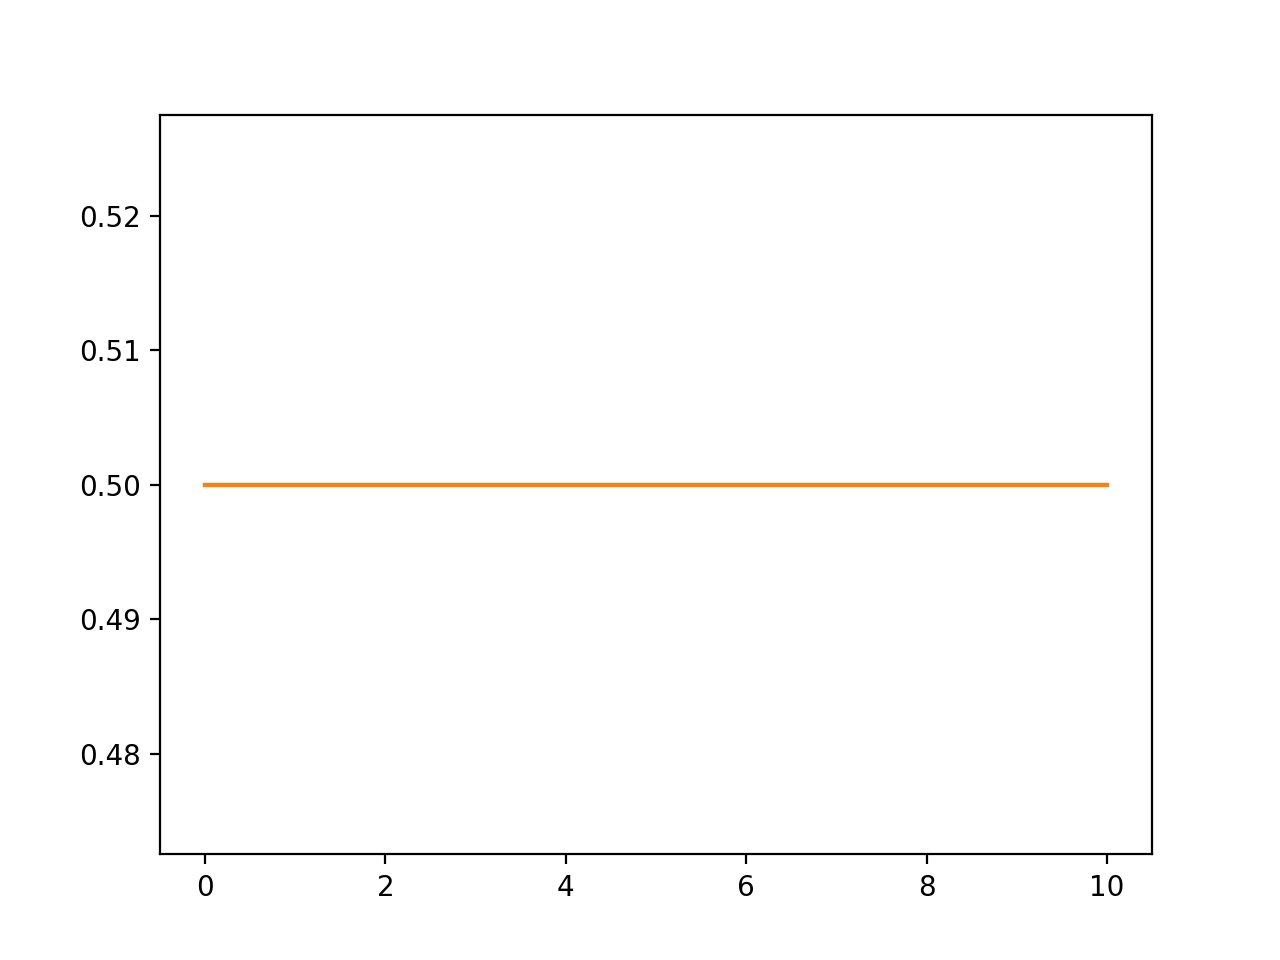

In [18]:
%matplotlib notebook
plt.plot(train_accuracy[1])
plt.plot(valid_accuracy[1])
plt.show()

In [ ]:
for t in range(n_tasks):
    test_loss = 0
    test_acc = 0
    loss_at = 0
    size = 0            
    batches = batch_loader(testY[t], 50, class_bal=True)
    for batch in batches:
        output, autoencoder_loss = net(testX[batch])
        size += batch.shape[0]
        temp = tf.convert_to_tensor(testY[t, batch].reshape(output.shape), dtype=tf.float32)
        test_loss += (custom_bce(output, temp) + autoencoder_loss) * batch.shape[0]
        loss_at += autoencoder_loss * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        test_acc += np.sum(output == testY[t, batch])
    test_losses[t].append(test_loss/size)
    test_accuracy[t].append(test_acc/size)
    test_autoencoder_loss[t].append(loss_at/size)

In [ ]:
data_dict = {'train_loss': train_losses,
             'valid_loss': valid_losses,
             'test_loss': test_losses,
             'train_acc': train_accuracy,
             'valid_acc': valid_accuracy,
             'test_acc': test_accuracy,
             'train_autoencoder_loss': train_autoencoder_loss,
             'valid_autoencoder_loss': valid_autoencoder_loss,
             'test_autoencoder_loss': test_autoencoder_loss}

pkl.dump(data_dict, open('dpn_data_dict.pkl', 'wb'))
print('Experiment completed')

In [18]:
data_dict = pkl.load(open('results/dpn_data_dict.pkl', 'rb'))
data_dict.keys()

dict_keys(['train_loss', 'valid_loss', 'test_loss', 'train_acc', 'valid_acc', 'test_acc', 'train_autoencoder_loss', 'valid_autoencoder_loss', 'test_autoencoder_loss'])

<IPython.core.display.Javascript object>


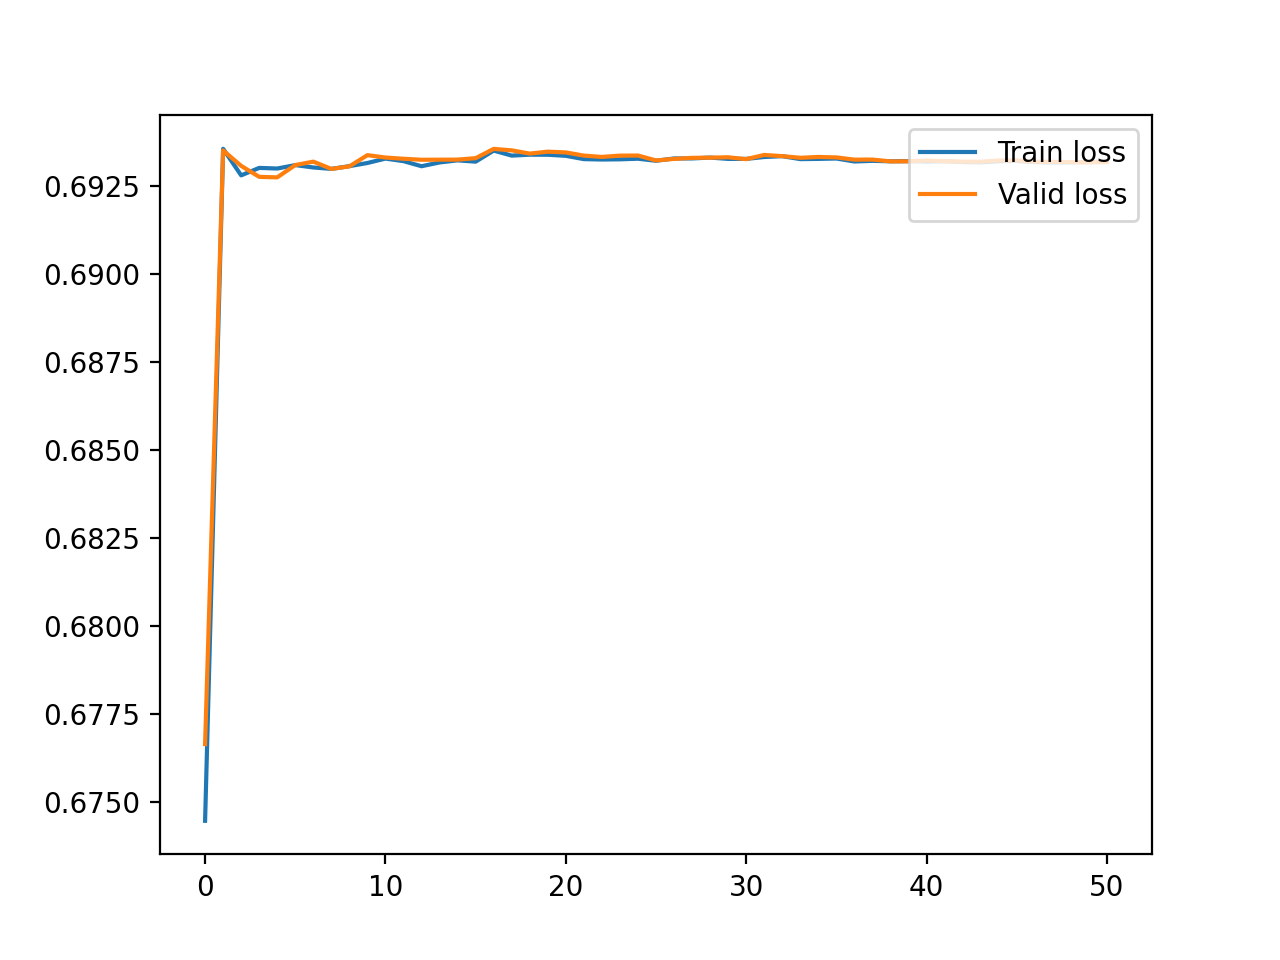

In [19]:
plt.plot(data_dict['train_loss'][0], label='Train loss')
plt.plot(data_dict['valid_loss'][0], label='Valid loss')
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


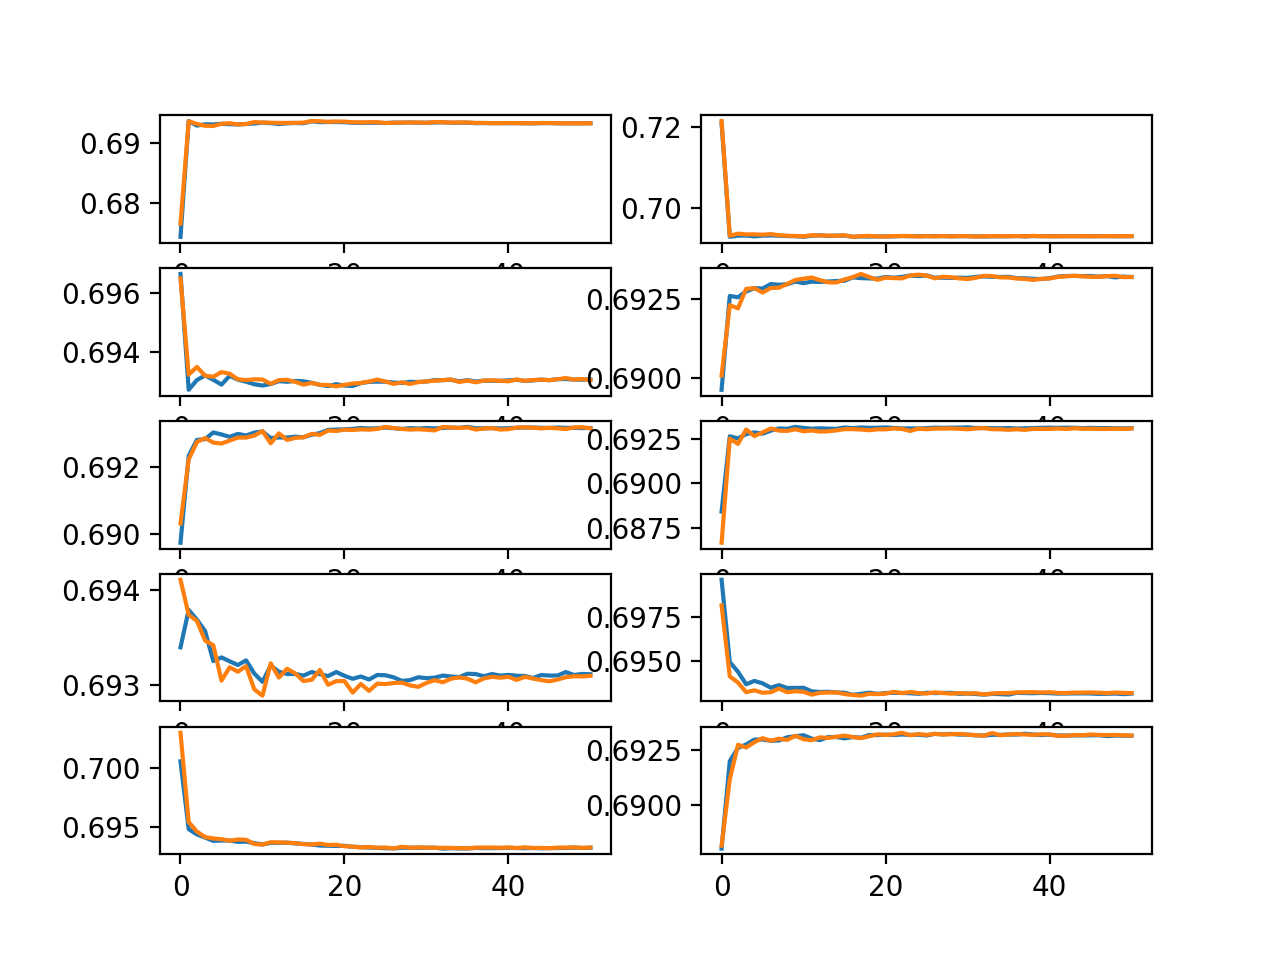

In [20]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_loss'][count])
        ax[r,c].plot(data_dict['valid_loss'][count])
        count += 1
plt.show()

<IPython.core.display.Javascript object>


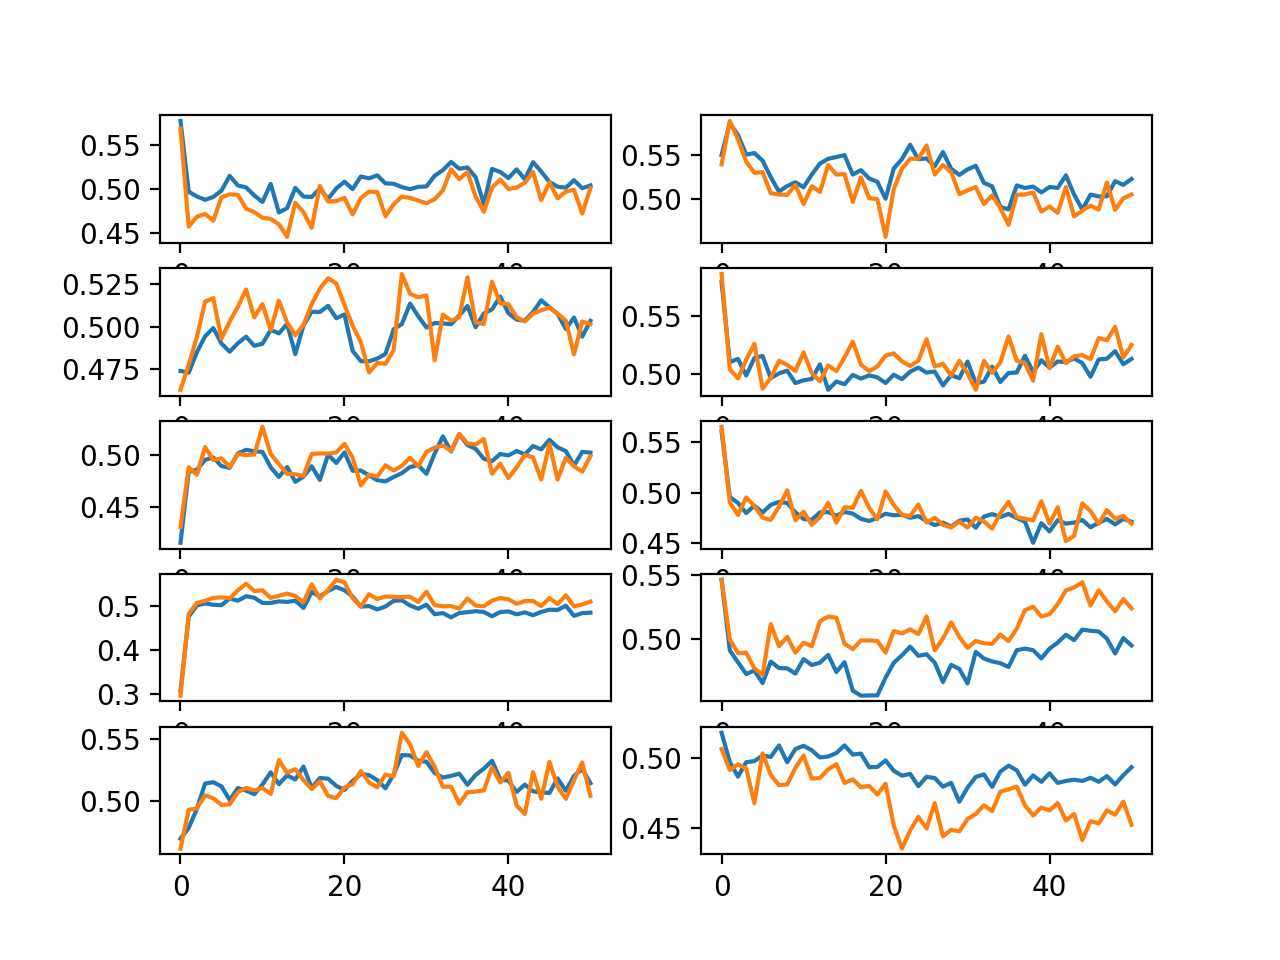

In [13]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_acc'][count])
        ax[r,c].plot(data_dict['valid_acc'][count])
        count += 1
plt.show()

<IPython.core.display.Javascript object>


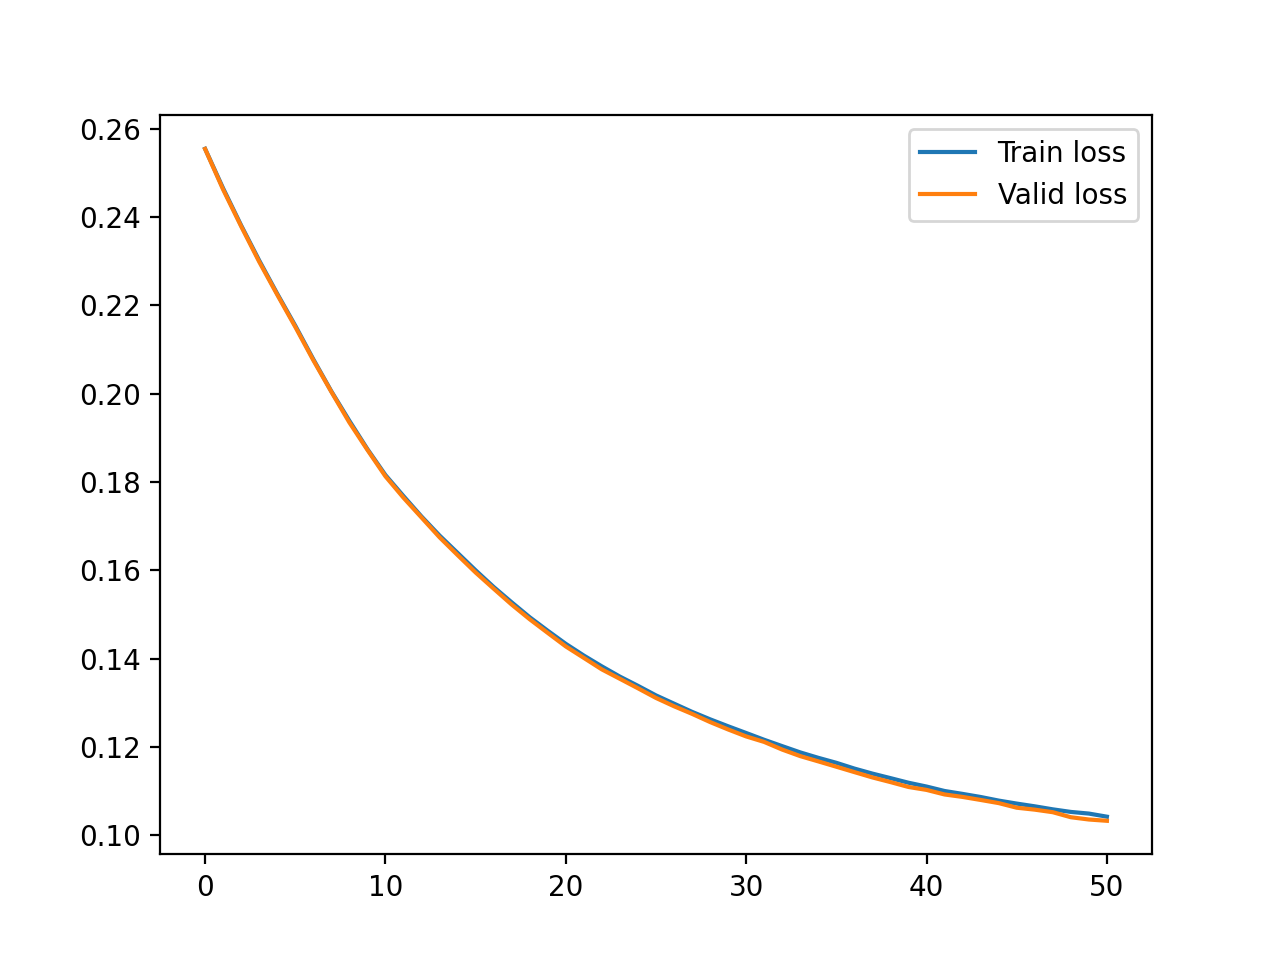

In [53]:
plt.plot(data_dict['train_autoencoder_loss'][0], label='Train loss')
plt.plot(data_dict['valid_autoencoder_loss'][0], label='Valid loss')
plt.legend(loc='upper right')
plt.show()